<center><h1>Predicting optimal nutrients for crops using ML</h1></center>

Downloaded from Kaggle: https://www.kaggle.com/atharvaingle/crop-recommendation-dataset/version/1

This Dataset has N,P,K from soil and other features from weather associated with different crops. Goal is to build a classifier for prediction of appropriate crop based on weather, and identify features important for each crop.

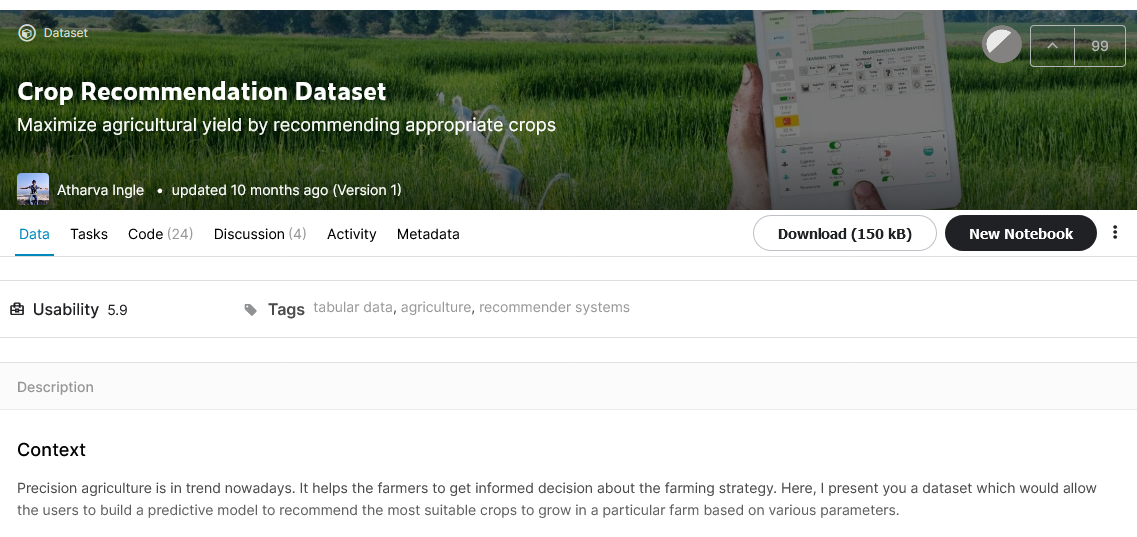

In [ ]:
import sys, os
import pandas as pd
import matplotlib as plt
import numpy as np
import seaborn as sns
import pycaret
pycaret.utils.version()

In [ ]:
#pip install shap
import shap

In [ ]:
#If you need to upgrade...
#!{sys.executable} -m pip install pycaret --upgrade --user

#Make sure you restart the kernel and run import commands again before proceeding

In [ ]:
file1 = pd.read_csv("Crop_recommendation.csv", header= 0, sep=",")
file1.head()

In [ ]:
file1.info()

In [ ]:
len(set(file1['label']))

We are going to perform classification of the data. PyCaret also has clustering and regression modules. You can check them out if you want to

## Classification

In [ ]:
from pycaret.classification import *

In [ ]:
data_setup = setup(data= file1, target='label')

We can obtain models using different methods:
1. We can simply ask PyCaret to compare all models (compare_models())
2. We can ask it to compare all models and select top 5 using the default metric (AUC score)
3. We can tune the parameters in each of the top 5 models and get better models
4. We can blend the top 5 tuned models and select the best model
5. Or we can simply do automl and select the best model that way

All of these approaches are demonstrated below

In [ ]:
top5 = compare_models(n_select = 5)

In [ ]:
top5

In [ ]:
tuned_models = [tune_model(i) for i in top5]
tuned_models

In [ ]:
blender = blend_models(estimator_list = tuned_models, choose_better = True)
blender

In [ ]:
bestModel = automl (optimize="F1")
bestModel

OK. Now you have got your best model. Time to evaluate how good it is

### Model evaluation

In [ ]:
plot_model(bestModel)

In [ ]:
evaluate_model(bestModel)

#CHECK OUT THE FEATURE IMPORTANCE PLOT -- THIS IS CALCULATED USING INTRINSIC METRICS FOR RANDOM FOREST
#IN THE NEXT BLOCK, YOU WILL GET SHAPLEY VALUES, WHICH ARE EXTRINSIC METRICS

#CLICK ON DIFFERENT TABS AND SEE WHAT THEY REPRESENT

#IF ANY OF THE TABS TAKE TOOOO LONG -- CLICK ON STOP BUTTON ABOVE

In [ ]:
interpret_model(bestModel)

__QUESTION__: Is there a difference in the feature importances based on Intrinsic and Extrinsic metrics? Think about why?

Its important to check if the model behaves well on the hold-out (validation) data

In [ ]:
predict_model(bestModel)

Overall, how do you think the model is doing?

## Looking back at the data to see why its doing so well

In [ ]:
file1.head()

In [ ]:
labels = set(file1['label'])
print (labels)
print ("# of crops: ", len(labels))

In [ ]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(20, 10))
#sns.boxplot(x=file1['label'], y=file1['humidity'])
sns.boxplot(x='label', y='humidity', data=file1,width=0.5)
sns.stripplot(x='label', y='humidity', data=file1, size=1, color=".1", linewidth=0)

In [ ]:
f, ax = plt.subplots(figsize=(20, 10))
#sns.boxplot(x=file1['label'], y=file1['humidity'])
sns.boxplot(x='label', y='ph', data=file1,width=0.5)
sns.stripplot(x='label', y='ph', data=file1, size=1, color=".1", linewidth=0)

Lets plot all variables one by one

In [ ]:
cnames = list(file1.columns)[:-1]
cnames

In [ ]:
for name in cnames:
    f, ax = plt.subplots(figsize=(20, 10))    
    ax.set(xlabel='Crops', ylabel=f'{name}')
    sns.boxplot(x='label', y=name, data=file1,width=0.5)
    plt.savefig('{}.png'.format(name))    

However, I would like to sort this by high to low for better visualization

In [ ]:

def boxplot_sorted(df, by, column):
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df2.median().sort_values(ascending = False)
    #print (meds.head())
    sns.boxplot(data=df2[meds.index],width=0.5)
    #sns.stripplot(x='label', y='humidity', data=file1, size=1, color=".1", linewidth=0)
    #df2[meds.index].boxplot(rot=90)

f, ax = plt.subplots(figsize=(20, 10))
boxplot_sorted(file1, by='label', column='rainfall')

In [ ]:
f, ax = plt.subplots(figsize=(20, 10))
boxplot_sorted(file1, by='label', column='rainfall')
#Change the column to different values and look at the effect


Does it make sense based on the Shapley values? Or is it difficult to tell?

Stare at these results for some time before you move ahead and see if anything above makes sense. 

Which factors are differentiating between the different crops?

## Unsupervised ML: Principal component analysis

In [ ]:
file1 = pd.read_csv("Crop_recommendation.csv", header= 0, sep=",")
file1.shape

In [ ]:
file1.head()

In [ ]:
x = file1[file1.columns.difference(['label'])]
y = file1['label']
x

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pc = pca.fit_transform(x)

In [ ]:
pc_df = pd.DataFrame(data = pc, columns = ['PC1', 'PC2','PC3','PC4', 'PC5'])
pc_df['label'] = y
pc_df.head()

In [ ]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':['PC1','PC2','PC3','PC4','PC5']})
sns.barplot(x='PC',y="var", 
           data=df, color="c");

for i in range(0,len(pca.explained_variance_ratio_)):
    value = pca.explained_variance_ratio_[i]
    print ("PC{}:{}".format(i+1,value))

You can see above that the first two PCs are explaning 0.40 + 0.34 = 0.74 i.e. 74% of the variation between the crops. That is good.

In [ ]:
pc_df

In [ ]:
ax = sns.lmplot( x="PC1", y="PC2",
  data=pc_df, 
  fit_reg=False, 
  hue='label', # color by cluster
  legend=True,
  palette="Set2",           
  scatter_kws={"s": 40},
  height=15) # specify the point size

* What does the above plot say?

* What are the two crops on the right? Why are they so different? You may want to look at the boxplots above to answer this question.

Let's plot a 3D plot so that we can see these points a little better

In [ ]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

In [ ]:
pc_df.label.unique()

In [ ]:
fig = plt.figure(figsize=(20,20))
ax=fig.add_subplot(111, projection = '3d')
ax.set_xlabel('PC1', fontsize=20)
ax.set_ylabel('PC2', fontsize=20)
ax.set_zlabel('PC3', fontsize=20)
for lab in pc_df.label.unique():    
    ax.scatter(pc_df.PC1[pc_df.label==lab],pc_df.PC2[pc_df.label==lab],pc_df.PC3[pc_df.label==lab],label=lab,
               s=30)
ax.legend()

### Figuring out which features are helping PC1 and PC2 explain the overall variation

In [ ]:
#Let's first extract out the PCA components from the pca object

imp = abs( pca.components_ )
print (imp)
print ("Shape of the components: ", imp.shape) 

The shape (5 rows, 7 columns) tells us that the rows are the PCs and the columns are the features (since we have 7 different features)

In [ ]:
sns.heatmap(imp, xticklabels = x.columns, yticklabels = ["PC1", "PC2", "PC3", "PC4", "PC5"], annot=True)

* Which feature is important discriminant for PC1?

* Which feature is important discriminant for PC2?

Take some time to look at the feature importances shown here and go back and compare with the boxplots of the features you exported as png (or shown above). 

* What did you learn from this exercise?

* If you wanted to plant some crop, would you be able to tell where to plant it?

* What additional information would you need for making such decisions?

* What is one caveat of the data we used for this?

# HOMEWORK

* Run the Mushroom Jupyter notebook

* Answer the questions in the notebook

* Submit answers in docx format before next Tuesday midnight